In [1]:
%pylab inline
import pandas as pd
import sys
import gc
import os
import lightgbm as lgb

Populating the interactive namespace from numpy and matplotlib


In [2]:
FOLD=1

In [3]:
print FOLD

1


In [4]:
sys.path.insert(0,"../python/rrvf2017/")

In [5]:
from rrvf_data import   DataGen, normalize
import rrvf_data

In [6]:
def get_index(cols,columns):
    lst=[]
    for c in cols:
        lst.append(np.where(columns==c)[0][0])
    return np.array(lst)

In [7]:
def read_data(offset):
    columns,data=rrvf_data.read_data( offset,"../input/train_test_extb.npy.npz",
                                     with_l2=True,with_l3=True,with_l4=True,with_l5=True)
    rawy=data[:,:,get_index(['visitors'],columns)[0]].copy()
    print len(columns),data.shape,rawy.shape    
    return columns,data,rawy

In [8]:
gc.collect()

0

# cv

In [9]:
from sklearn.linear_model import Ridge

In [10]:
n_reg_lookback=7
n_lookforward=1
n_offset=0

In [11]:
lag_cols=['weekday6', 'weekday5', 'weekday4', 'weekday3', 'weekday2', 'weekday1', 'weekday0', 'const_one', 'visitors', 'geo1_visitors_mean', 'geo2_visitors_mean', 'station_visitors_mean', 'genre_name_visitors_mean', 'day_of_week_visitors_mean', 'visitor_lag7', 'visitor_lag14', 'visitor_lag28', 'visitor_lag91', 'visitor_lag182', 'visitor_lag364', 'visitor_ma2', 'visitor_ma4', 'visitor_ma7', 'visitor_ma14', 'visitor_ma28', 'visitor_ma56', 'visitor_ma112', 'visitor_ma224', 'visitor_sma1', 'visitor_sma2', 'visitor_sma3', 'visitor_sma4', 'visitor_sma8', 'visitor_sma16', 'visitor_sma32', 'visitors_minus_ma28', 'visitors_divid_ma28', 'all_count_y1', 'geo1_count_y1', 'station_count_y1', 'geo2_count_y1', 'all_count_y2', 'geo1_count_y2', 'station_count_y2', 'geo2_count_y2', 'all_count_y3', 'geo1_count_y3', 'station_count_y3', 'geo2_count_y3', 'all_count_y4', 'geo1_count_y4', 'station_count_y4', 'geo2_count_y4', 'all_count_y5', 'geo1_count_y5', 'station_count_y5', 'geo2_count_y5', 'TMAX', 'TMIN', 'TAVG', 'PRCP', 'holiday', 's16_y_nan', 's16_y_std', 's16_y1_ratio', 's16_y2_ratio', 'f_t', 'bad_ratio', 'rv_sum', 'rv_mean', 'rv_gap_mean', 'rv_gap_weighted_mean']
len(lag_cols)

72

In [12]:
def make_ondate_train_test(ondate_cols,data,columns):
    ondate_train_test=np.round(data[:,:,get_index(ondate_cols,columns)].copy(),2)
    ondate_train_test=normalize(ondate_train_test)
    v=np.zeros_like(ondate_train_test[:,:,0])
    for i in range(v.shape[0]): v[i]=i
    #ondate_train_test = np.concatenate([np.expand_dims(v,-1),ondate_train_test],axis=-1)
    print ondate_train_test.shape
    return ondate_train_test

In [13]:
ondate_cols =array(['const_one', 'visitor_lag91', 'visitor_lag182', 'TMIN', 'holiday', 'TAVG','f_t',
                    'weekday6', 'weekday5', 'weekday4', 'weekday3', 'weekday2', 'weekday1', 'weekday0',
                    'rv_sum', 'rv_mean', 'rv_gap_mean', 'rv_gap_weighted_mean',
                    '3003nb_conv_fold{}_False_d478.pkl', '3005_rf_fold{}_False_d478.pkl', '3001eb_lgb_fold{}_True_d478.pkl', '3002nb_lstm_fold{}_False_d478.pkl', '3000eb_ridge_fold{}_True_d478.pkl', '3002_lstm_fold{}_False_d478.pkl', '3006_xgb_fold{}_False_d478.pkl', '3003_conv_fold{}_False_d478.pkl', '3000_ridge_fold{}_False_d478.pkl', '3001_lgb_fold{}_False_d478.pkl'                                        ,
                    'l2_3000_ridge_fold{}_False_d478.pkl', 'l2_3003_conv_fold{}_False_d478.pkl', 'l2_3001_lgb_fold{}_False_d478.pkl', 'l2_3006_xgb_fold{}_False_d478.pkl',
                    'l3_3000_ridge_fold{}_False_d478.pkl', 'l3_3003_conv_fold{}_False_d478.pkl', 'l3_3006_xgb_fold{}_False_d478.pkl', 'l3_3001_lgb_fold{}_False_d478.pkl'                    ,
                    'l4_3006_xgb_fold{}_False_d478.pkl', 'l4_3000_ridge_fold{}_False_d478.pkl', 'l4_3001_lgb_fold{}_False_d478.pkl', 'l4_3003_conv_fold{}_False_d478.pkl'
                   ])

In [14]:
def make_lag_train_test(lag_cols,data,columns):
    lag_train_test=data[:,:,get_index(lag_cols,columns)].copy()
    #lag_train_test=normalize(lag_train_test)
    print lag_train_test.shape
    return lag_train_test

In [15]:
from sklearn.model_selection import GridSearchCV,ParameterGrid,ParameterSampler
from sklearn.metrics import  make_scorer
from multiprocessing import Pool

# time split

In [16]:
import cPickle as pickle
indexes=rrvf_data.get_train_valid_indexes()

In [17]:
def make_Xy(data_from_gen):
    print data_from_gen[0]['ondatex'].shape,data_from_gen[0]['lagx'].shape,data_from_gen[0]['masky'].shape,data_from_gen[1].shape
    X=np.concatenate([data_from_gen[0]['ondatex'].reshape([data_from_gen[0]['ondatex'].shape[0],-1]),
                    data_from_gen[0]['lagx'].reshape([data_from_gen[0]['lagx'].shape[0],-1])],axis=1)
    y=np.squeeze(data_from_gen[1])
    mask=np.squeeze(data_from_gen[0]['masky'].reshape([data_from_gen[0]['masky'].shape[0],-1]))
    print X.shape,y.shape,mask.shape
    mask= (mask>0) & (y>0)
    X=X[mask]
    X=np.concatenate([X,np.isnan(X)],axis=1).astype(np.float32)
    X[np.isnan(X)]=0    
    y=y[mask]
    dataidx=data_from_gen[3][mask]
    assert X.shape[0]==y.shape[0]
    return X,y,dataidx

In [18]:
from sklearn.metrics import mean_squared_error
def make_model(i, trainX,trainy, validX,validy, colsample_bytree=1,num_leaves=31,subsample=1,
               learning_rate=0.03,max_bin=127,
               min_data_in_leaf=20,lambda_l2=0,
               min_sum_hessian_in_leaf=1e-3, C=0.001,
               objective='binary' ):
        models=[]
        scores=[]
        gbm = Ridge(alpha=3)
        gbm.fit(trainX,trainy)

        models.append(gbm)
        validpred=gbm.predict(validX)
        scores.append(mean_squared_error(validy,validpred))
        print mean_squared_error(trainy,gbm.predict(trainX)), scores[-1]
        print scores
        print i, "mean score", np.mean(scores)
        return models[0],np.mean(scores),validpred
        #return np.mean(scores) 

In [19]:
def f(iparam,trainX,trainy,validX,validy):
    i,param=iparam
    return make_model(i,trainX,trainy,validX,validy, **param)

In [20]:
import rrvf_data
def g(model,testX,testy,testidx,n_offset):
    test_pred=model.predict(testX)    
    df=pd.DataFrame({'y':testy})
    df['pred']=test_pred
    df['dayidx']=testidx[:,1]+n_offset
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    print df2['error2'].mean()
    display(df2)
    return  df2['error2'].mean()

def g2(model,train_gen,offset):
    predlist=[]
    ylist=[]
    daylist=[]
    for i in range(7):
        i=478-7+i-offset
        Xdict,y,dataidx,_=train_gen.get_by_t2(day=i)
        X=np.concatenate([Xdict['ondatex'].reshape([Xdict['ondatex'].shape[0],-1]),
                    Xdict['lagx'].reshape([Xdict['lagx'].shape[0],-1])],axis=1)
        X=np.concatenate([X,np.isnan(X)],1)
        X[np.isnan(X)]=0        
        pred=model.predict(X).reshape(-1)
        predlist.append(pred)
        daylist.append(np.zeros_like(pred,dtype=int)+i+offset)
        ylist.append(y.reshape(-1))
    ylist=np.concatenate(ylist)
    predlist=np.concatenate(predlist)
    daylist=np.concatenate(daylist)
    df=pd.DataFrame({'y':ylist,'dayidx':daylist,'pred':predlist})
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    print df2['error2'].mean()
    display(df2)
    return  df2['error2'].mean()

PRED_DATE=478
def h(model,train_gen):
    Xdict,_,dataidx,_=train_gen.get_by_t2(day=PRED_DATE)
    X=np.concatenate([Xdict['ondatex'].reshape([Xdict['ondatex'].shape[0],-1]),
                    Xdict['lagx'].reshape([Xdict['lagx'].shape[0],-1])],axis=1)
    X=np.concatenate([X,np.isnan(X)],axis=1).astype(np.float32)
    X[np.isnan(X)]=0    
    #mask=np.squeeze(Xdict['masky'].reshape([Xdict.shape[0],-1]))
    print X.shape
    pred=model.predict(X)
    return pred,dataidx


In [21]:
parameter={'colsample_bytree': 0.5,
 'lambda_l2': 1,
 'learning_rate': 0.05,
 'max_bin': 255,
 'min_data_in_leaf': 30,
 'min_sum_hessian_in_leaf': 0.001,
 'num_leaves': 127,
 'objective': 'regression',
 'subsample': 0.8}

In [22]:
EXCLUDE_HARD=False
def _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    assert n_offset+1==n_lookforward
    batchsize=128
    ondate_train_test=make_ondate_train_test(ondate_cols,data,columns)
    lag_train_test = make_lag_train_test(lag_cols,data,columns)
    train_gen=rrvf_data.DataGen(lag_train_test,ondate_train_test, rawy,n_reg_lookback+1, 478,#478-1*7-39-n_offset, 
                      batchsize=batchsize,valid_split=0.1, indexes=index,lookforward_offset=n_offset,
                      exclude_hard=EXCLUDE_HARD,
                  lookback1=n_reg_lookback,  lookforward=n_lookforward, excluded_days=None)
    valid_gen=None
    test_gen=rrvf_data.DataGen(lag_train_test,ondate_train_test, rawy,478-1*7-n_offset,478, lookforward_offset=n_offset,
                     batchsize=batchsize,lookback1=n_reg_lookback, lookforward=n_lookforward)
    print train_gen.train_steps_per_epoch
    print 0 if valid_gen is None else valid_gen.train_steps_per_epoch
    
    train_data_from_gen=train_gen.get_train()
    trainX,trainy,_=make_Xy(train_data_from_gen)
    valid_data_from_gen=train_gen.get_valid()
    validX,validy,valididx=make_Xy(valid_data_from_gen)
    test_data_from_gen=test_gen.get_train()
    testX,testy,testidx=make_Xy(test_data_from_gen)

    model,score,validpred=f((-1,parameter),trainX,trainy,validX,validy)
    g(model,testX,testy,testidx,n_offset)
    g2(model,train_gen,n_offset)
    
    pred478=h(model,train_gen)
    return score,(validy,valididx,validpred),pred478

def run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    return _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset)        

In [23]:
def MSE(a,b):
    idx= np.isnan(a) | np.isnan(b)
    a=a[~idx]
    b=b[~idx]
    #print np.mean(~idx)
    return np.mean((a-b)**2)
    return mean_squared_error(a,b)

In [24]:
j=FOLD
validpreds={}
for offset in range(1,40):
    print "\n\n",offset
    columns,data,rawy=read_data(offset=offset)
    _,validpred,pred478=run_once(columns,data,rawy, indexes[j],ondate_cols,lag_cols,n_lookforward=offset,n_offset=offset-1)
    validpreds[offset]=[validpred,pred478]
pickle.dump(validpreds, open('l5_3000_ridge_fold{}_{}_d{}.pkl'.format(j, EXCLUDE_HARD, PRED_DATE),'wb'))



1
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 14.804288
(829, 517, 40)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (200606, 2) (50134, 2)
train/valid # (200606, 2) (50134, 2)
rand split across time
train has 200606 records out of 389630 records
valid has 50134 records out of 389630 records
train has 5803 records out of 5803 records
no valid set
1567
0
(200606, 1, 40) (200606, 7, 72) (200606, 1) (200606, 1)
(200606, 544) (200606,) (200606,)
(50134, 1, 40) (50134, 7, 72) (50134, 1) (50134, 1)
(50134, 544) (50134,) (50134,)
(5803, 1, 40) (5803, 7, 72) (5803, 1) (5803, 1)
(5803, 544) (5803,) (5803,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  
/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 7.52246806512e-11 / 5.96046447754e-08
  RuntimeWarning)


0.24041821 0.24717335
[0.24717335]
-1 mean score 0.24717335
0.213704243302


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.933023 -0.003913  0.227745    7  2017-04-16
472     2.507290  2.539629 -0.032339  0.236340    1  2017-04-17
473     2.661330  2.670314 -0.008984  0.250735    2  2017-04-18
474     2.754815  2.745258  0.009557  0.205772    3  2017-04-19
475     2.713762  2.714761 -0.000999  0.231803    4  2017-04-20
476     2.999000  2.988165  0.010835  0.156746    5  2017-04-21
477     3.075529  3.077380 -0.001851  0.186789    6  2017-04-22

0.213704243302


pred         y     error    error2  day        date
dayidx                                                         
471     2.933023  2.929110 -0.003913  0.227745    7  2017-04-16
472     2.539629  2.507290 -0.032339  0.236340    1  2017-04-17
473     2.670314  2.661330 -0.008984  0.250735    2  2017-04-18
474     2.745258  2.754815  0.009557  0.205772    3  2017-04-19
475     2.714761  2.713762 -0.000999  0.231803    4  2017-04-20
476     2.988165  2.999000  0.010835  0.156746    5  2017-04-21
477     3.077380  3.075529 -0.001851  0.186789    6  2017-04-22

(829, 1088)


2
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 14.804288
(829, 517, 40)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (200381, 2) (50076, 2)
train/valid # (200381, 2) (50076, 2)
rand split across time
train has 200381 records out of 389630 records
valid has 50076 records out of 389630 records
train has 6632 records out of 6632 records
no valid set
1565
0
(200381, 1, 40) (200381, 7, 72) (200381, 1) (200381, 1)
(200381, 544) (200381,) (200381,)
(50076, 1, 40) (50076, 7, 72) (50076, 1) (50076, 1)
(50076, 544) (50076,) (50076,)
(6632, 1, 40) (6632, 7, 72) (6632, 1) (6632, 1)
(6632, 544) (6632,) (6632,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.486166884e-10 / 5.96046447754e-08
  RuntimeWarning)


0.24505569 0.25133026
[0.25133026]
-1 mean score 0.25133026
0.216320797801


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.929409 -0.000299  0.233267    7  2017-04-16
472     2.507290  2.527878 -0.020588  0.238224    1  2017-04-17
473     2.661330  2.667116 -0.005787  0.250156    2  2017-04-18
474     2.754815  2.753652  0.001163  0.212667    3  2017-04-19
475     2.713762  2.719539 -0.005777  0.235746    4  2017-04-20
476     2.999000  2.990404  0.008595  0.159812    5  2017-04-21
477     3.075529  3.067957  0.007572  0.184373    6  2017-04-22

0.216320797801


pred         y     error    error2  day        date
dayidx                                                         
471     2.929409  2.929110 -0.000299  0.233267    7  2017-04-16
472     2.527878  2.507290 -0.020588  0.238224    1  2017-04-17
473     2.667116  2.661330 -0.005786  0.250156    2  2017-04-18
474     2.753652  2.754815  0.001163  0.212667    3  2017-04-19
475     2.719539  2.713762 -0.005777  0.235746    4  2017-04-20
476     2.990405  2.999000  0.008595  0.159812    5  2017-04-21
477     3.067957  3.075529  0.007572  0.184373    6  2017-04-22

(829, 1088)


3
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 14.804288
(829, 517, 40)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (200200, 2) (50030, 2)
train/valid # (200200, 2) (50030, 2)
rand split across time
train has 200200 records out of 389630 records
valid has 50030 records out of 389630 records
train has 7461 records out of 7461 records
no valid set
1564
0
(200200, 1, 40) (200200, 7, 72) (200200, 1) (200200, 1)
(200200, 544) (200200,) (200200,)
(50030, 1, 40) (50030, 7, 72) (50030, 1) (50030, 1)
(50030, 544) (50030,) (50030,)
(7461, 1, 40) (7461, 7, 72) (7461, 1) (7461, 1)
(7461, 544) (7461,) (7461,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.45262815665e-10 / 5.96046447754e-08
  RuntimeWarning)


0.24736659 0.25259343
[0.25259343]
-1 mean score 0.25259343
0.221007332206


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.909496  0.019614  0.231593    7  2017-04-16
472     2.507290  2.515752 -0.008461  0.238844    1  2017-04-17
473     2.661330  2.655225  0.006105  0.262600    2  2017-04-18
474     2.754815  2.767223 -0.012409  0.221674    3  2017-04-19
475     2.713762  2.721122 -0.007360  0.240711    4  2017-04-20
476     2.999000  2.980126  0.018874  0.162236    5  2017-04-21
477     3.075529  3.058968  0.016561  0.189393    6  2017-04-22

0.221007332206


pred         y     error    error2  day        date
dayidx                                                         
471     2.909496  2.929110  0.019614  0.231593    7  2017-04-16
472     2.515752  2.507290 -0.008461  0.238844    1  2017-04-17
473     2.655225  2.661330  0.006105  0.262600    2  2017-04-18
474     2.767223  2.754815 -0.012409  0.221674    3  2017-04-19
475     2.721122  2.713762 -0.007360  0.240711    4  2017-04-20
476     2.980126  2.999000  0.018874  0.162236    5  2017-04-21
477     3.058968  3.075529  0.016561  0.189393    6  2017-04-22

(829, 1088)


4
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 14.804288
(829, 517, 40)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (200042, 2) (49986, 2)
train/valid # (200042, 2) (49986, 2)
rand split across time
train has 200042 records out of 389630 records
valid has 49986 records out of 389630 records
train has 8290 records out of 8290 records
no valid set
1562
0
(200042, 1, 40) (200042, 7, 72) (200042, 1) (200042, 1)
(200042, 544) (200042,) (200042,)
(49986, 1, 40) (49986, 7, 72) (49986, 1) (49986, 1)
(49986, 544) (49986,) (49986,)
(8290, 1, 40) (8290, 7, 72) (8290, 1) (8290, 1)
(8290, 544) (8290,) (8290,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.3196065074e-10 / 5.96046447754e-08
  RuntimeWarning)


0.24875942 0.25471961
[0.25471961]
-1 mean score 0.25471961
0.221057996154


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.908669  0.020441  0.239648    7  2017-04-16
472     2.507290  2.513453 -0.006163  0.236459    1  2017-04-17
473     2.661330  2.632565  0.028765  0.260325    2  2017-04-18
474     2.754815  2.754225  0.000590  0.215974    3  2017-04-19
475     2.713762  2.720628 -0.006866  0.240623    4  2017-04-20
476     2.999000  2.967483  0.031517  0.166531    5  2017-04-21
477     3.075529  3.055211  0.020318  0.187847    6  2017-04-22

0.221057996154


pred         y     error    error2  day        date
dayidx                                                         
471     2.908669  2.929110  0.020441  0.239648    7  2017-04-16
472     2.513453  2.507290 -0.006163  0.236459    1  2017-04-17
473     2.632565  2.661330  0.028765  0.260325    2  2017-04-18
474     2.754225  2.754815  0.000590  0.215974    3  2017-04-19
475     2.720628  2.713762 -0.006866  0.240623    4  2017-04-20
476     2.967483  2.999000  0.031517  0.166531    5  2017-04-21
477     3.055211  3.075529  0.020318  0.187847    6  2017-04-22

(829, 1088)


5
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 14.804288
(829, 517, 40)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (199839, 2) (49937, 2)
train/valid # (199839, 2) (49937, 2)
rand split across time
train has 199839 records out of 389630 records
valid has 49937 records out of 389630 records
train has 9119 records out of 9119 records
no valid set
1561
0
(199839, 1, 40) (199839, 7, 72) (199839, 1) (199839, 1)
(199839, 544) (199839,) (199839,)
(49937, 1, 40) (49937, 7, 72) (49937, 1) (49937, 1)
(49937, 544) (49937,) (49937,)
(9119, 1, 40) (9119, 7, 72) (9119, 1) (9119, 1)
(9119, 544) (9119,) (9119,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.33191110918e-10 / 5.96046447754e-08
  RuntimeWarning)


0.25074285 0.2562521
[0.2562521]
-1 mean score 0.2562521
0.223753809929


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.914498  0.014612  0.234942    7  2017-04-16
472     2.507290  2.526544 -0.019253  0.245139    1  2017-04-17
473     2.661330  2.624610  0.036720  0.263698    2  2017-04-18
474     2.754815  2.733178  0.021637  0.215325    3  2017-04-19
475     2.713762  2.703780  0.009981  0.247139    4  2017-04-20
476     2.999000  2.963857  0.035143  0.169837    5  2017-04-21
477     3.075529  3.048001  0.027528  0.190198    6  2017-04-22

0.223753809929


pred         y     error    error2  day        date
dayidx                                                         
471     2.914498  2.929110  0.014612  0.234942    7  2017-04-16
472     2.526544  2.507290 -0.019253  0.245139    1  2017-04-17
473     2.624610  2.661330  0.036720  0.263698    2  2017-04-18
474     2.733178  2.754815  0.021637  0.215325    3  2017-04-19
475     2.703780  2.713762  0.009981  0.247139    4  2017-04-20
476     2.963857  2.999000  0.035143  0.169837    5  2017-04-21
477     3.048001  3.075529  0.027528  0.190198    6  2017-04-22

(829, 1088)


6
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 15.133374
(829, 517, 40)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (199631, 2) (49882, 2)
train/valid # (199631, 2) (49882, 2)
rand split across time
train has 199631 records out of 389630 records
valid has 49882 records out of 389630 records
train has 9948 records out of 9948 records
no valid set
1559
0
(199631, 1, 40) (199631, 7, 72) (199631, 1) (199631, 1)
(199631, 544) (199631,) (199631,)
(49882, 1, 40) (49882, 7, 72) (49882, 1) (49882, 1)
(49882, 544) (49882,) (49882,)
(9948, 1, 40) (9948, 7, 72) (9948, 1) (9948, 1)
(9948, 544) (9948,) (9948,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.21562523936e-10 / 5.96046447754e-08
  RuntimeWarning)


0.25152323 0.2579109
[0.2579109]
-1 mean score 0.2579109
0.227219924331


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.925939  0.003171  0.242435    7  2017-04-16
472     2.507290  2.533745 -0.026455  0.251800    1  2017-04-17
473     2.661330  2.628968  0.032362  0.270325    2  2017-04-18
474     2.754815  2.737138  0.017677  0.217859    3  2017-04-19
475     2.713762  2.723007 -0.009245  0.248593    4  2017-04-20
476     2.999000  2.956151  0.042849  0.170856    5  2017-04-21
477     3.075529  3.070868  0.004661  0.188670    6  2017-04-22

0.227219924331


pred         y     error    error2  day        date
dayidx                                                         
471     2.925939  2.929110  0.003171  0.242435    7  2017-04-16
472     2.533745  2.507290 -0.026455  0.251800    1  2017-04-17
473     2.628968  2.661330  0.032362  0.270325    2  2017-04-18
474     2.737138  2.754815  0.017677  0.217859    3  2017-04-19
475     2.723007  2.713762 -0.009245  0.248593    4  2017-04-20
476     2.956151  2.999000  0.042849  0.170856    5  2017-04-21
477     3.070868  3.075529  0.004661  0.188670    6  2017-04-22

(829, 1088)


7
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 16.310143
(829, 517, 40)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (199412, 2) (49827, 2)
train/valid # (199412, 2) (49827, 2)
rand split across time
train has 199412 records out of 389630 records
valid has 49827 records out of 389630 records
train has 10777 records out of 10777 records
no valid set
1557
0
(199412, 1, 40) (199412, 7, 72) (199412, 1) (199412, 1)
(199412, 544) (199412,) (199412,)
(49827, 1, 40) (49827, 7, 72) (49827, 1) (49827, 1)
(49827, 544) (49827,) (49827,)
(10777, 1, 40) (10777, 7, 72) (10777, 1) (10777, 1)
(10777, 544) (10777,) (10777,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.31393756986e-10 / 5.96046447754e-08
  RuntimeWarning)


0.25393194 0.26012605
[0.26012605]
-1 mean score 0.26012605
0.227690473199


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.922253  0.006857  0.245478    7  2017-04-16
472     2.507290  2.546060 -0.038769  0.252686    1  2017-04-17
473     2.661330  2.639872  0.021458  0.271653    2  2017-04-18
474     2.754815  2.732466  0.022348  0.217272    3  2017-04-19
475     2.713762  2.713696  0.000066  0.250812    4  2017-04-20
476     2.999000  2.980602  0.018398  0.164117    5  2017-04-21
477     3.075529  3.094545 -0.019016  0.191815    6  2017-04-22

0.227690458298


pred         y     error    error2  day        date
dayidx                                                         
471     2.922253  2.929110  0.006857  0.245478    7  2017-04-16
472     2.546060  2.507290 -0.038769  0.252686    1  2017-04-17
473     2.639872  2.661330  0.021458  0.271653    2  2017-04-18
474     2.732466  2.754815  0.022348  0.217272    3  2017-04-19
475     2.713696  2.713762  0.000066  0.250812    4  2017-04-20
476     2.980602  2.999000  0.018398  0.164117    5  2017-04-21
477     3.094545  3.075529 -0.019016  0.191815    6  2017-04-22

(829, 1088)


8
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 17.574337
(829, 517, 40)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (199179, 2) (49770, 2)
train/valid # (199179, 2) (49770, 2)
rand split across time
train has 199179 records out of 389630 records
valid has 49770 records out of 389630 records
train has 11606 records out of 11606 records
no valid set
1556
0
(199179, 1, 40) (199179, 7, 72) (199179, 1) (199179, 1)
(199179, 544) (199179,) (199179,)
(49770, 1, 40) (49770, 7, 72) (49770, 1) (49770, 1)
(49770, 544) (49770,) (49770,)
(11606, 1, 40) (11606, 7, 72) (11606, 1) (11606, 1)
(11606, 544) (11606,) (11606,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.34630306903e-10 / 5.96046447754e-08
  RuntimeWarning)


0.25760245 0.26500297
[0.26500297]
-1 mean score 0.26500297
0.232694163918


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.938179 -0.009069  0.255163    7  2017-04-16
472     2.507290  2.547903 -0.040612  0.248583    1  2017-04-17
473     2.661330  2.652240  0.009090  0.275558    2  2017-04-18
474     2.754815  2.735904  0.018911  0.228974    3  2017-04-19
475     2.713762  2.714608 -0.000847  0.254624    4  2017-04-20
476     2.999000  2.963331  0.035669  0.173811    5  2017-04-21
477     3.075529  3.091974 -0.016445  0.192148    6  2017-04-22

0.232694163918


pred         y     error    error2  day        date
dayidx                                                         
471     2.938179  2.929110 -0.009069  0.255163    7  2017-04-16
472     2.547903  2.507290 -0.040612  0.248583    1  2017-04-17
473     2.652240  2.661330  0.009090  0.275558    2  2017-04-18
474     2.735904  2.754815  0.018911  0.228974    3  2017-04-19
475     2.714608  2.713762 -0.000847  0.254624    4  2017-04-20
476     2.963331  2.999000  0.035669  0.173811    5  2017-04-21
477     3.091974  3.075529 -0.016445  0.192148    6  2017-04-22

(829, 1088)


9
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 18.806503
(829, 517, 40)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (198954, 2) (49713, 2)
train/valid # (198954, 2) (49713, 2)
rand split across time
train has 198954 records out of 389630 records
valid has 49713 records out of 389630 records
train has 12435 records out of 12435 records
no valid set
1554
0
(198954, 1, 40) (198954, 7, 72) (198954, 1) (198954, 1)
(198954, 544) (198954,) (198954,)
(49713, 1, 40) (49713, 7, 72) (49713, 1) (49713, 1)
(49713, 544) (49713,) (49713,)
(12435, 1, 40) (12435, 7, 72) (12435, 1) (12435, 1)
(12435, 544) (12435,) (12435,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.26004415235e-10 / 5.96046447754e-08
  RuntimeWarning)


0.25990343 0.2667302
[0.2667302]
-1 mean score 0.2667302
0.232238993049


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.923186  0.005924  0.255530    7  2017-04-16
472     2.507290  2.556438 -0.049148  0.249041    1  2017-04-17
473     2.661330  2.669050 -0.007720  0.278387    2  2017-04-18
474     2.754815  2.733245  0.021569  0.230251    3  2017-04-19
475     2.713762  2.715725 -0.001963  0.249654    4  2017-04-20
476     2.999000  2.969131  0.029869  0.171091    5  2017-04-21
477     3.075529  3.084140 -0.008610  0.191720    6  2017-04-22

0.232238993049


pred         y     error    error2  day        date
dayidx                                                         
471     2.923186  2.929110  0.005924  0.255530    7  2017-04-16
472     2.556438  2.507290 -0.049148  0.249041    1  2017-04-17
473     2.669050  2.661330 -0.007720  0.278387    2  2017-04-18
474     2.733245  2.754815  0.021569  0.230251    3  2017-04-19
475     2.715725  2.713762 -0.001963  0.249654    4  2017-04-20
476     2.969131  2.999000  0.029869  0.171091    5  2017-04-21
477     3.084140  3.075529 -0.008610  0.191720    6  2017-04-22

(829, 1088)


10
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 19.926521
(829, 517, 40)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (198785, 2) (49666, 2)
train/valid # (198785, 2) (49666, 2)
rand split across time
train has 198785 records out of 389630 records
valid has 49666 records out of 389630 records
train has 13264 records out of 13264 records
no valid set
1553
0
(198785, 1, 40) (198785, 7, 72) (198785, 1) (198785, 1)
(198785, 544) (198785,) (198785,)
(49666, 1, 40) (49666, 7, 72) (49666, 1) (49666, 1)
(49666, 544) (49666,) (49666,)
(13264, 1, 40) (13264, 7, 72) (13264, 1) (13264, 1)
(13264, 544) (13264,) (13264,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.15593930261e-10 / 5.96046447754e-08
  RuntimeWarning)


0.26077786 0.26640868
[0.26640868]
-1 mean score 0.26640868
0.231706261635


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.921164  0.007946  0.250698    7  2017-04-16
472     2.507290  2.543914 -0.036623  0.249770    1  2017-04-17
473     2.661330  2.673207 -0.011877  0.278614    2  2017-04-18
474     2.754815  2.747475  0.007340  0.226258    3  2017-04-19
475     2.713762  2.722821 -0.009059  0.250974    4  2017-04-20
476     2.999000  2.972347  0.026653  0.172347    5  2017-04-21
477     3.075529  3.093560 -0.018031  0.193283    6  2017-04-22

0.231706276536


pred         y     error    error2  day        date
dayidx                                                         
471     2.921164  2.929110  0.007946  0.250698    7  2017-04-16
472     2.543914  2.507290 -0.036623  0.249770    1  2017-04-17
473     2.673207  2.661330 -0.011877  0.278614    2  2017-04-18
474     2.747475  2.754815  0.007340  0.226258    3  2017-04-19
475     2.722821  2.713762 -0.009059  0.250974    4  2017-04-20
476     2.972347  2.999000  0.026653  0.172347    5  2017-04-21
477     3.093560  3.075529 -0.018031  0.193283    6  2017-04-22

(829, 1088)


11
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 21.05768
(829, 517, 40)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (198605, 2) (49620, 2)
train/valid # (198605, 2) (49620, 2)
rand split across time
train has 198605 records out of 389630 records
valid has 49620 records out of 389630 records
train has 14093 records out of 14093 records
no valid set
1551
0
(198605, 1, 40) (198605, 7, 72) (198605, 1) (198605, 1)
(198605, 544) (198605,) (198605,)
(49620, 1, 40) (49620, 7, 72) (49620, 1) (49620, 1)
(49620, 544) (49620,) (49620,)
(14093, 1, 40) (14093, 7, 72) (14093, 1) (14093, 1)
(14093, 544) (14093,) (14093,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.19952686672e-10 / 5.96046447754e-08
  RuntimeWarning)


0.26139942 0.2679496
[0.2679496]
-1 mean score 0.2679496
0.232262521982


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.908911  0.020199  0.248651    7  2017-04-16
472     2.507290  2.545277 -0.037987  0.251635    1  2017-04-17
473     2.661330  2.661688 -0.000359  0.279898    2  2017-04-18
474     2.754815  2.722615  0.032200  0.228953    3  2017-04-19
475     2.713762  2.730969 -0.017208  0.250439    4  2017-04-20
476     2.999000  2.978394  0.020606  0.173404    5  2017-04-21
477     3.075529  3.072652  0.002877  0.192858    6  2017-04-22

0.232262521982


pred         y     error    error2  day        date
dayidx                                                         
471     2.908911  2.929110  0.020199  0.248651    7  2017-04-16
472     2.545277  2.507290 -0.037987  0.251635    1  2017-04-17
473     2.661688  2.661330 -0.000359  0.279898    2  2017-04-18
474     2.722615  2.754815  0.032200  0.228953    3  2017-04-19
475     2.730969  2.713762 -0.017208  0.250439    4  2017-04-20
476     2.978394  2.999000  0.020606  0.173404    5  2017-04-21
477     3.072652  3.075529  0.002877  0.192858    6  2017-04-22

(829, 1088)


12
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 22.115147
(829, 517, 40)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (198392, 2) (49566, 2)
train/valid # (198392, 2) (49566, 2)
rand split across time
train has 198392 records out of 389630 records
valid has 49566 records out of 389630 records
train has 14922 records out of 14922 records
no valid set
1549
0
(198392, 1, 40) (198392, 7, 72) (198392, 1) (198392, 1)
(198392, 544) (198392,) (198392,)
(49566, 1, 40) (49566, 7, 72) (49566, 1) (49566, 1)
(49566, 544) (49566,) (49566,)
(14922, 1, 40) (14922, 7, 72) (14922, 1) (14922, 1)
(14922, 544) (14922,) (14922,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.30532876175e-10 / 5.96046447754e-08
  RuntimeWarning)


0.26283738 0.26997796
[0.26997796]
-1 mean score 0.26997796
0.233152285218


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.903258  0.025852  0.253052    7  2017-04-16
472     2.507290  2.551283 -0.043992  0.250566    1  2017-04-17
473     2.661330  2.666470 -0.005140  0.276908    2  2017-04-18
474     2.754815  2.722454  0.032361  0.230400    3  2017-04-19
475     2.713762  2.732548 -0.018786  0.249727    4  2017-04-20
476     2.999000  2.973619  0.025380  0.177341    5  2017-04-21
477     3.075529  3.080009 -0.004479  0.194073    6  2017-04-22

0.233152315021


pred         y     error    error2  day        date
dayidx                                                         
471     2.903258  2.929110  0.025852  0.253052    7  2017-04-16
472     2.551283  2.507290 -0.043992  0.250566    1  2017-04-17
473     2.666470  2.661330 -0.005140  0.276908    2  2017-04-18
474     2.722454  2.754815  0.032361  0.230400    3  2017-04-19
475     2.732548  2.713762 -0.018786  0.249727    4  2017-04-20
476     2.973619  2.999000  0.025380  0.177341    5  2017-04-21
477     3.080009  3.075529 -0.004479  0.194073    6  2017-04-22

(829, 1088)


13
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 23.15517
(829, 517, 40)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (198182, 2) (49513, 2)
train/valid # (198182, 2) (49513, 2)
rand split across time
train has 198182 records out of 389630 records
valid has 49513 records out of 389630 records
train has 15751 records out of 15751 records
no valid set
1548
0
(198182, 1, 40) (198182, 7, 72) (198182, 1) (198182, 1)
(198182, 544) (198182,) (198182,)
(49513, 1, 40) (49513, 7, 72) (49513, 1) (49513, 1)
(49513, 544) (49513,) (49513,)
(15751, 1, 40) (15751, 7, 72) (15751, 1) (15751, 1)
(15751, 544) (15751,) (15751,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.47953468921e-10 / 5.96046447754e-08
  RuntimeWarning)


0.26367837 0.2701083
[0.2701083]
-1 mean score 0.2701083
0.234490901232


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.908540  0.020570  0.257446    7  2017-04-16
472     2.507290  2.538802 -0.031512  0.256429    1  2017-04-17
473     2.661330  2.670785 -0.009456  0.278196    2  2017-04-18
474     2.754815  2.724998  0.029817  0.232900    3  2017-04-19
475     2.713762  2.733780 -0.020018  0.252957    4  2017-04-20
476     2.999000  3.003045 -0.004045  0.174039    5  2017-04-21
477     3.075529  3.068715  0.006814  0.189469    6  2017-04-22

0.234490901232


pred         y     error    error2  day        date
dayidx                                                         
471     2.908540  2.929110  0.020570  0.257446    7  2017-04-16
472     2.538802  2.507290 -0.031512  0.256429    1  2017-04-17
473     2.670785  2.661330 -0.009456  0.278196    2  2017-04-18
474     2.724998  2.754815  0.029817  0.232900    3  2017-04-19
475     2.733780  2.713762 -0.020018  0.252957    4  2017-04-20
476     3.003045  2.999000 -0.004045  0.174039    5  2017-04-21
477     3.068715  3.075529  0.006814  0.189469    6  2017-04-22

(829, 1088)


14
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 24.22639
(829, 517, 40)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (197959, 2) (49458, 2)
train/valid # (197959, 2) (49458, 2)
rand split across time
train has 197959 records out of 389630 records
valid has 49458 records out of 389630 records
train has 16580 records out of 16580 records
no valid set
1546
0
(197959, 1, 40) (197959, 7, 72) (197959, 1) (197959, 1)
(197959, 544) (197959,) (197959,)
(49458, 1, 40) (49458, 7, 72) (49458, 1) (49458, 1)
(49458, 544) (49458,) (49458,)
(16580, 1, 40) (16580, 7, 72) (16580, 1) (16580, 1)
(16580, 544) (16580,) (16580,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.35887537334e-10 / 5.96046447754e-08
  RuntimeWarning)


0.26502022 0.27139646
[0.27139646]
-1 mean score 0.27139646
0.234848126769


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.906824  0.022286  0.261244    7  2017-04-16
472     2.507290  2.531070 -0.023779  0.251836    1  2017-04-17
473     2.661330  2.661809 -0.000479  0.281291    2  2017-04-18
474     2.754815  2.720894  0.033921  0.236060    3  2017-04-19
475     2.713762  2.728674 -0.014912  0.248939    4  2017-04-20
476     2.999000  3.007034 -0.008034  0.167320    5  2017-04-21
477     3.075529  3.077506 -0.001976  0.197246    6  2017-04-22

0.234848156571


pred         y     error    error2  day        date
dayidx                                                         
471     2.906824  2.929110  0.022286  0.261244    7  2017-04-16
472     2.531069  2.507290 -0.023779  0.251836    1  2017-04-17
473     2.661809  2.661330 -0.000479  0.281291    2  2017-04-18
474     2.720894  2.754815  0.033921  0.236060    3  2017-04-19
475     2.728674  2.713762 -0.014912  0.248939    4  2017-04-20
476     3.007034  2.999000 -0.008034  0.167320    5  2017-04-21
477     3.077506  3.075529 -0.001976  0.197246    6  2017-04-22

(829, 1088)


15
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 25.357664
(829, 517, 40)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (197725, 2) (49402, 2)
train/valid # (197725, 2) (49402, 2)
rand split across time
train has 197725 records out of 389630 records
valid has 49402 records out of 389630 records
train has 17409 records out of 17409 records
no valid set
1544
0
(197725, 1, 40) (197725, 7, 72) (197725, 1) (197725, 1)
(197725, 544) (197725,) (197725,)
(49402, 1, 40) (49402, 7, 72) (49402, 1) (49402, 1)
(49402, 544) (49402,) (49402,)
(17409, 1, 40) (17409, 7, 72) (17409, 1) (17409, 1)
(17409, 544) (17409,) (17409,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.26046409421e-10 / 5.96046447754e-08
  RuntimeWarning)


0.26867217 0.27356467
[0.27356467]
-1 mean score 0.27356467
0.240681096911


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.909156  0.019954  0.271894    7  2017-04-16
472     2.507290  2.537873 -0.030583  0.255454    1  2017-04-17
473     2.661330  2.645636  0.015693  0.290997    2  2017-04-18
474     2.754815  2.713226  0.041588  0.234414    3  2017-04-19
475     2.713762  2.730786 -0.017025  0.258694    4  2017-04-20
476     2.999000  3.001986 -0.002986  0.176331    5  2017-04-21
477     3.075529  3.076723 -0.001194  0.196984    6  2017-04-22

0.240681096911


pred         y     error    error2  day        date
dayidx                                                         
471     2.909156  2.929110  0.019954  0.271894    7  2017-04-16
472     2.537873  2.507290 -0.030583  0.255454    1  2017-04-17
473     2.645636  2.661330  0.015693  0.290997    2  2017-04-18
474     2.713226  2.754815  0.041588  0.234414    3  2017-04-19
475     2.730786  2.713762 -0.017025  0.258694    4  2017-04-20
476     3.001986  2.999000 -0.002986  0.176331    5  2017-04-21
477     3.076723  3.075529 -0.001194  0.196984    6  2017-04-22

(829, 1088)


16
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 26.465925
(829, 517, 40)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (197493, 2) (49345, 2)
train/valid # (197493, 2) (49345, 2)
rand split across time
train has 197493 records out of 389630 records
valid has 49345 records out of 389630 records
train has 18238 records out of 18238 records
no valid set
1542
0
(197493, 1, 40) (197493, 7, 72) (197493, 1) (197493, 1)
(197493, 544) (197493,) (197493,)
(49345, 1, 40) (49345, 7, 72) (49345, 1) (49345, 1)
(49345, 544) (49345,) (49345,)
(18238, 1, 40) (18238, 7, 72) (18238, 1) (18238, 1)
(18238, 544) (18238,) (18238,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.2217571399e-10 / 5.96046447754e-08
  RuntimeWarning)


0.2704534 0.2768263
[0.2768263]
-1 mean score 0.2768263
0.24116627872


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.903798  0.025312  0.271483    7  2017-04-16
472     2.507290  2.539417 -0.032127  0.256944    1  2017-04-17
473     2.661330  2.638773  0.022556  0.290043    2  2017-04-18
474     2.754815  2.705766  0.049048  0.237875    3  2017-04-19
475     2.713762  2.721586 -0.007824  0.256477    4  2017-04-20
476     2.999000  2.994807  0.004193  0.178717    5  2017-04-21
477     3.075529  3.056403  0.019126  0.196626    6  2017-04-22

0.24116627872


pred         y     error    error2  day        date
dayidx                                                         
471     2.903798  2.929110  0.025312  0.271483    7  2017-04-16
472     2.539417  2.507290 -0.032127  0.256944    1  2017-04-17
473     2.638773  2.661330  0.022556  0.290043    2  2017-04-18
474     2.705766  2.754815  0.049048  0.237875    3  2017-04-19
475     2.721586  2.713762 -0.007824  0.256477    4  2017-04-20
476     2.994807  2.999000  0.004193  0.178717    5  2017-04-21
477     3.056403  3.075529  0.019126  0.196626    6  2017-04-22

(829, 1088)


17
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 27.605818
(829, 517, 40)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (197331, 2) (49305, 2)
train/valid # (197331, 2) (49305, 2)
rand split across time
train has 197331 records out of 389630 records
valid has 49305 records out of 389630 records
train has 19067 records out of 19067 records
no valid set
1541
0
(197331, 1, 40) (197331, 7, 72) (197331, 1) (197331, 1)
(197331, 544) (197331,) (197331,)
(49305, 1, 40) (49305, 7, 72) (49305, 1) (49305, 1)
(49305, 544) (49305,) (49305,)
(19067, 1, 40) (19067, 7, 72) (19067, 1) (19067, 1)
(19067, 544) (19067,) (19067,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.35053815353e-10 / 5.96046447754e-08
  RuntimeWarning)


0.27163216 0.2766113
[0.2766113]
-1 mean score 0.2766113
0.242664813995


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.910469  0.018641  0.270015    7  2017-04-16
472     2.507290  2.519459 -0.012168  0.257436    1  2017-04-17
473     2.661330  2.630910  0.030420  0.291298    2  2017-04-18
474     2.754815  2.699968  0.054847  0.248131    3  2017-04-19
475     2.713762  2.713032  0.000730  0.256179    4  2017-04-20
476     2.999000  2.991353  0.007647  0.179190    5  2017-04-21
477     3.075529  3.050438  0.025091  0.196405    6  2017-04-22

0.242664813995


pred         y     error    error2  day        date
dayidx                                                         
471     2.910469  2.929110  0.018641  0.270015    7  2017-04-16
472     2.519459  2.507290 -0.012168  0.257436    1  2017-04-17
473     2.630910  2.661330  0.030420  0.291298    2  2017-04-18
474     2.699968  2.754815  0.054847  0.248131    3  2017-04-19
475     2.713032  2.713762  0.000730  0.256179    4  2017-04-20
476     2.991353  2.999000  0.007647  0.179190    5  2017-04-21
477     3.050438  3.075529  0.025091  0.196405    6  2017-04-22

(829, 1088)


18
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 28.75126
(829, 517, 40)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (197143, 2) (49257, 2)
train/valid # (197143, 2) (49257, 2)
rand split across time
train has 197143 records out of 389630 records
valid has 49257 records out of 389630 records
train has 19896 records out of 19896 records
no valid set
1540
0
(197143, 1, 40) (197143, 7, 72) (197143, 1) (197143, 1)
(197143, 544) (197143,) (197143,)
(49257, 1, 40) (49257, 7, 72) (49257, 1) (49257, 1)
(49257, 544) (49257,) (49257,)
(19896, 1, 40) (19896, 7, 72) (19896, 1) (19896, 1)
(19896, 544) (19896,) (19896,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.25968388498e-10 / 5.96046447754e-08
  RuntimeWarning)


0.2725347 0.2773544
[0.2773544]
-1 mean score 0.2773544
0.245046302676


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.915360  0.013750  0.275307    7  2017-04-16
472     2.507290  2.523300 -0.016009  0.261094    1  2017-04-17
473     2.661330  2.626007  0.035323  0.290936    2  2017-04-18
474     2.754815  2.711999  0.042815  0.239661    3  2017-04-19
475     2.713762  2.716727 -0.002966  0.265682    4  2017-04-20
476     2.999000  2.991361  0.007639  0.181266    5  2017-04-21
477     3.075529  3.054106  0.021424  0.201379    6  2017-04-22

0.245046332479


pred         y     error    error2  day        date
dayidx                                                         
471     2.915360  2.929110  0.013750  0.275307    7  2017-04-16
472     2.523300  2.507290 -0.016009  0.261094    1  2017-04-17
473     2.626007  2.661330  0.035323  0.290936    2  2017-04-18
474     2.711999  2.754815  0.042815  0.239661    3  2017-04-19
475     2.716727  2.713762 -0.002966  0.265682    4  2017-04-20
476     2.991361  2.999000  0.007639  0.181266    5  2017-04-21
477     3.054106  3.075529  0.021424  0.201379    6  2017-04-22

(829, 1088)


19
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 29.798643
(829, 517, 40)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (196929, 2) (49206, 2)
train/valid # (196929, 2) (49206, 2)
rand split across time
train has 196929 records out of 389630 records
valid has 49206 records out of 389630 records
train has 20725 records out of 20725 records
no valid set
1538
0
(196929, 1, 40) (196929, 7, 72) (196929, 1) (196929, 1)
(196929, 544) (196929,) (196929,)
(49206, 1, 40) (49206, 7, 72) (49206, 1) (49206, 1)
(49206, 544) (49206,) (49206,)
(20725, 1, 40) (20725, 7, 72) (20725, 1) (20725, 1)
(20725, 544) (20725,) (20725,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.21240642525e-10 / 5.96046447754e-08
  RuntimeWarning)


0.27333558 0.27783322
[0.27783322]
-1 mean score 0.27783322
0.247574090958


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.932522 -0.003412  0.277058    7  2017-04-16
472     2.507290  2.520562 -0.013271  0.262425    1  2017-04-17
473     2.661330  2.617451  0.043879  0.291361    2  2017-04-18
474     2.754815  2.696763  0.058051  0.246142    3  2017-04-19
475     2.713762  2.701664  0.012098  0.264754    4  2017-04-20
476     2.999000  2.980419  0.018581  0.184757    5  2017-04-21
477     3.075529  3.042757  0.032772  0.206521    6  2017-04-22

0.247574090958


pred         y     error    error2  day        date
dayidx                                                         
471     2.932522  2.929110 -0.003412  0.277058    7  2017-04-16
472     2.520562  2.507290 -0.013271  0.262425    1  2017-04-17
473     2.617451  2.661330  0.043879  0.291361    2  2017-04-18
474     2.696763  2.754815  0.058051  0.246142    3  2017-04-19
475     2.701664  2.713762  0.012098  0.264754    4  2017-04-20
476     2.980419  2.999000  0.018581  0.184757    5  2017-04-21
477     3.042757  3.075529  0.032772  0.206521    6  2017-04-22

(829, 1088)


20
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 30.796307
(829, 517, 40)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (196711, 2) (49150, 2)
train/valid # (196711, 2) (49150, 2)
rand split across time
train has 196711 records out of 389630 records
valid has 49150 records out of 389630 records
train has 21554 records out of 21554 records
no valid set
1536
0
(196711, 1, 40) (196711, 7, 72) (196711, 1) (196711, 1)
(196711, 544) (196711,) (196711,)
(49150, 1, 40) (49150, 7, 72) (49150, 1) (49150, 1)
(49150, 544) (49150,) (49150,)
(21554, 1, 40) (21554, 7, 72) (21554, 1) (21554, 1)
(21554, 544) (21554,) (21554,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.19818877042e-10 / 5.96046447754e-08
  RuntimeWarning)


0.27383906 0.27741084
[0.27741084]
-1 mean score 0.27741084
0.244759827852


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.926820  0.002290  0.267135    7  2017-04-16
472     2.507290  2.543921 -0.036630  0.261188    1  2017-04-17
473     2.661330  2.624562  0.036768  0.284831    2  2017-04-18
474     2.754815  2.700011  0.054804  0.245780    3  2017-04-19
475     2.713762  2.700831  0.012931  0.270539    4  2017-04-20
476     2.999000  2.969913  0.029086  0.181054    5  2017-04-21
477     3.075529  3.059046  0.016484  0.202792    6  2017-04-22

0.244759827852


pred         y     error    error2  day        date
dayidx                                                         
471     2.926820  2.929110  0.002290  0.267135    7  2017-04-16
472     2.543921  2.507290 -0.036630  0.261188    1  2017-04-17
473     2.624562  2.661330  0.036768  0.284831    2  2017-04-18
474     2.700011  2.754815  0.054804  0.245780    3  2017-04-19
475     2.700831  2.713762  0.012931  0.270539    4  2017-04-20
476     2.969913  2.999000  0.029086  0.181054    5  2017-04-21
477     3.059046  3.075529  0.016484  0.202792    6  2017-04-22

(829, 1088)


21
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 31.792852
(829, 517, 40)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (196485, 2) (49095, 2)
train/valid # (196485, 2) (49095, 2)
rand split across time
train has 196485 records out of 389630 records
valid has 49095 records out of 389630 records
train has 22383 records out of 22383 records
no valid set
1535
0
(196485, 1, 40) (196485, 7, 72) (196485, 1) (196485, 1)
(196485, 544) (196485,) (196485,)
(49095, 1, 40) (49095, 7, 72) (49095, 1) (49095, 1)
(49095, 544) (49095,) (49095,)
(22383, 1, 40) (22383, 7, 72) (22383, 1) (22383, 1)
(22383, 544) (22383,) (22383,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.08481418293e-10 / 5.96046447754e-08
  RuntimeWarning)


0.2749602 0.2785233
[0.2785233]
-1 mean score 0.2785233
0.249265983701


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.902287  0.026823  0.280495    7  2017-04-16
472     2.507290  2.523808 -0.016518  0.261835    1  2017-04-17
473     2.661330  2.635476  0.025854  0.291516    2  2017-04-18
474     2.754815  2.700541  0.054273  0.247803    3  2017-04-19
475     2.713762  2.678077  0.035684  0.271203    4  2017-04-20
476     2.999000  2.964550  0.034450  0.188348    5  2017-04-21
477     3.075529  3.053151  0.022378  0.203662    6  2017-04-22

0.249265983701


pred         y     error    error2  day        date
dayidx                                                         
471     2.902287  2.929110  0.026823  0.280495    7  2017-04-16
472     2.523808  2.507290 -0.016518  0.261835    1  2017-04-17
473     2.635476  2.661330  0.025854  0.291516    2  2017-04-18
474     2.700541  2.754815  0.054273  0.247803    3  2017-04-19
475     2.678077  2.713762  0.035684  0.271203    4  2017-04-20
476     2.964550  2.999000  0.034450  0.188348    5  2017-04-21
477     3.053151  3.075529  0.022378  0.203662    6  2017-04-22

(829, 1088)


22
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 32.870983
(829, 517, 40)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (196255, 2) (49037, 2)
train/valid # (196255, 2) (49037, 2)
rand split across time
train has 196255 records out of 389630 records
valid has 49037 records out of 389630 records
train has 23212 records out of 23212 records
no valid set
1533
0
(196255, 1, 40) (196255, 7, 72) (196255, 1) (196255, 1)
(196255, 544) (196255,) (196255,)
(49037, 1, 40) (49037, 7, 72) (49037, 1) (49037, 1)
(49037, 544) (49037,) (49037,)
(23212, 1, 40) (23212, 7, 72) (23212, 1) (23212, 1)
(23212, 544) (23212,) (23212,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.00091157584e-10 / 5.96046447754e-08
  RuntimeWarning)


0.27736872 0.28114998
[0.28114998]
-1 mean score 0.28114998
0.248833909631


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.912630  0.016480  0.272214    7  2017-04-16
472     2.507290  2.507571 -0.000280  0.264803    1  2017-04-17
473     2.661330  2.641617  0.019713  0.285679    2  2017-04-18
474     2.754815  2.717467  0.037348  0.248296    3  2017-04-19
475     2.713762  2.691042  0.022719  0.274992    4  2017-04-20
476     2.999000  2.961420  0.037579  0.189115    5  2017-04-21
477     3.075529  3.047328  0.028202  0.206739    6  2017-04-22

0.248833909631


pred         y     error    error2  day        date
dayidx                                                         
471     2.912630  2.929110  0.016480  0.272214    7  2017-04-16
472     2.507571  2.507290 -0.000280  0.264803    1  2017-04-17
473     2.641617  2.661330  0.019713  0.285679    2  2017-04-18
474     2.717467  2.754815  0.037348  0.248296    3  2017-04-19
475     2.691042  2.713762  0.022719  0.274992    4  2017-04-20
476     2.961421  2.999000  0.037579  0.189115    5  2017-04-21
477     3.047328  3.075529  0.028202  0.206739    6  2017-04-22

(829, 1088)


23
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 33.974537
(829, 517, 40)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (196025, 2) (48978, 2)
train/valid # (196025, 2) (48978, 2)
rand split across time
train has 196025 records out of 389630 records
valid has 48978 records out of 389630 records
train has 24041 records out of 24041 records
no valid set
1531
0
(196025, 1, 40) (196025, 7, 72) (196025, 1) (196025, 1)
(196025, 544) (196025,) (196025,)
(48978, 1, 40) (48978, 7, 72) (48978, 1) (48978, 1)
(48978, 544) (48978,) (48978,)
(24041, 1, 40) (24041, 7, 72) (24041, 1) (24041, 1)
(24041, 544) (24041,) (24041,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.21883850235e-10 / 5.96046447754e-08
  RuntimeWarning)


0.27851802 0.2834264
[0.2834264]
-1 mean score 0.2834264
0.247648224235


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.914472  0.014638  0.269104    7  2017-04-16
472     2.507290  2.504999  0.002292  0.263758    1  2017-04-17
473     2.661330  2.657471  0.003858  0.286763    2  2017-04-18
474     2.754815  2.715387  0.039428  0.246884    3  2017-04-19
475     2.713762  2.713525  0.000237  0.270972    4  2017-04-20
476     2.999000  2.969798  0.029201  0.192836    5  2017-04-21
477     3.075529  3.049071  0.026458  0.203222    6  2017-04-22

0.247648224235


pred         y     error    error2  day        date
dayidx                                                         
471     2.914472  2.929110  0.014638  0.269104    7  2017-04-16
472     2.504999  2.507290  0.002292  0.263758    1  2017-04-17
473     2.657471  2.661330  0.003858  0.286763    2  2017-04-18
474     2.715387  2.754815  0.039428  0.246884    3  2017-04-19
475     2.713525  2.713762  0.000237  0.270972    4  2017-04-20
476     2.969798  2.999000  0.029201  0.192836    5  2017-04-21
477     3.049071  3.075529  0.026458  0.203222    6  2017-04-22

(829, 1088)


24
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 35.208443
(829, 517, 40)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (195855, 2) (48933, 2)
train/valid # (195855, 2) (48933, 2)
rand split across time
train has 195855 records out of 389630 records
valid has 48933 records out of 389630 records
train has 24870 records out of 24870 records
no valid set
1530
0
(195855, 1, 40) (195855, 7, 72) (195855, 1) (195855, 1)
(195855, 544) (195855,) (195855,)
(48933, 1, 40) (48933, 7, 72) (48933, 1) (48933, 1)
(48933, 544) (48933,) (48933,)
(24870, 1, 40) (24870, 7, 72) (24870, 1) (24870, 1)
(24870, 544) (24870,) (24870,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.44744619068e-10 / 5.96046447754e-08
  RuntimeWarning)


0.27920258 0.2840273
[0.2840273]
-1 mean score 0.2840273
0.246981903911


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.915301  0.013809  0.270381    7  2017-04-16
472     2.507290  2.502321  0.004969  0.261205    1  2017-04-17
473     2.661330  2.643220  0.018109  0.286741    2  2017-04-18
474     2.754815  2.724578  0.030237  0.245321    3  2017-04-19
475     2.713762  2.696445  0.017317  0.269507    4  2017-04-20
476     2.999000  2.980260  0.018740  0.190162    5  2017-04-21
477     3.075529  3.053641  0.021889  0.205556    6  2017-04-22

0.246981889009


pred         y     error    error2  day        date
dayidx                                                         
471     2.915301  2.929110  0.013809  0.270381    7  2017-04-16
472     2.502322  2.507290  0.004969  0.261205    1  2017-04-17
473     2.643220  2.661330  0.018109  0.286741    2  2017-04-18
474     2.724578  2.754815  0.030237  0.245321    3  2017-04-19
475     2.696445  2.713762  0.017317  0.269507    4  2017-04-20
476     2.980260  2.999000  0.018740  0.190162    5  2017-04-21
477     3.053641  3.075529  0.021889  0.205556    6  2017-04-22

(829, 1088)


25
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 36.335064
(829, 517, 40)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (195669, 2) (48889, 2)
train/valid # (195669, 2) (48889, 2)
rand split across time
train has 195669 records out of 389630 records
valid has 48889 records out of 389630 records
train has 25699 records out of 25699 records
no valid set
1528
0
(195669, 1, 40) (195669, 7, 72) (195669, 1) (195669, 1)
(195669, 544) (195669,) (195669,)
(48889, 1, 40) (48889, 7, 72) (48889, 1) (48889, 1)
(48889, 544) (48889,) (48889,)
(25699, 1, 40) (25699, 7, 72) (25699, 1) (25699, 1)
(25699, 544) (25699,) (25699,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.50710388613e-10 / 5.96046447754e-08
  RuntimeWarning)


0.2799904 0.28448924
[0.28448924]
-1 mean score 0.28448924
0.249193459749


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.912059  0.017051  0.270234    7  2017-04-16
472     2.507290  2.489940  0.017351  0.265779    1  2017-04-17
473     2.661330  2.641490  0.019839  0.292155    2  2017-04-18
474     2.754815  2.708101  0.046714  0.250861    3  2017-04-19
475     2.713762  2.685767  0.027995  0.270589    4  2017-04-20
476     2.999000  2.984242  0.014757  0.186686    5  2017-04-21
477     3.075529  3.075084  0.000445  0.208051    6  2017-04-22

0.249193459749


pred         y     error    error2  day        date
dayidx                                                         
471     2.912059  2.929110  0.017051  0.270234    7  2017-04-16
472     2.489940  2.507290  0.017351  0.265779    1  2017-04-17
473     2.641490  2.661330  0.019839  0.292155    2  2017-04-18
474     2.708101  2.754815  0.046714  0.250861    3  2017-04-19
475     2.685767  2.713762  0.027995  0.270589    4  2017-04-20
476     2.984242  2.999000  0.014757  0.186686    5  2017-04-21
477     3.075084  3.075529  0.000445  0.208051    6  2017-04-22

(829, 1088)


26
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 37.374123
(829, 517, 40)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (195451, 2) (48836, 2)
train/valid # (195451, 2) (48836, 2)
rand split across time
train has 195451 records out of 389630 records
valid has 48836 records out of 389630 records
train has 26528 records out of 26528 records
no valid set
1526
0
(195451, 1, 40) (195451, 7, 72) (195451, 1) (195451, 1)
(195451, 544) (195451,) (195451,)
(48836, 1, 40) (48836, 7, 72) (48836, 1) (48836, 1)
(48836, 544) (48836,) (48836,)
(26528, 1, 40) (26528, 7, 72) (26528, 1) (26528, 1)
(26528, 544) (26528,) (26528,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.32544045184e-10 / 5.96046447754e-08
  RuntimeWarning)


0.28099307 0.28614262
[0.28614262]
-1 mean score 0.28614262
0.250602483749


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.918702  0.010408  0.279898    7  2017-04-16
472     2.507290  2.501549  0.005741  0.260773    1  2017-04-17
473     2.661330  2.634175  0.027155  0.294038    2  2017-04-18
474     2.754815  2.713384  0.041430  0.245547    3  2017-04-19
475     2.713762  2.680389  0.033373  0.278943    4  2017-04-20
476     2.999000  2.980488  0.018511  0.190155    5  2017-04-21
477     3.075529  3.062147  0.013382  0.204863    6  2017-04-22

0.250602483749


pred         y     error    error2  day        date
dayidx                                                         
471     2.918702  2.929110  0.010408  0.279898    7  2017-04-16
472     2.501549  2.507290  0.005741  0.260773    1  2017-04-17
473     2.634175  2.661330  0.027155  0.294038    2  2017-04-18
474     2.713384  2.754815  0.041430  0.245547    3  2017-04-19
475     2.680389  2.713762  0.033373  0.278943    4  2017-04-20
476     2.980488  2.999000  0.018511  0.190155    5  2017-04-21
477     3.062147  3.075529  0.013382  0.204863    6  2017-04-22

(829, 1088)


27
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 38.450596
(829, 517, 40)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (195240, 2) (48779, 2)
train/valid # (195240, 2) (48779, 2)
rand split across time
train has 195240 records out of 389630 records
valid has 48779 records out of 389630 records
train has 27357 records out of 27357 records
no valid set
1525
0
(195240, 1, 40) (195240, 7, 72) (195240, 1) (195240, 1)
(195240, 544) (195240,) (195240,)
(48779, 1, 40) (48779, 7, 72) (48779, 1) (48779, 1)
(48779, 544) (48779,) (48779,)
(27357, 1, 40) (27357, 7, 72) (27357, 1) (27357, 1)
(27357, 544) (27357,) (27357,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.34954658559e-10 / 5.96046447754e-08
  RuntimeWarning)


0.28175527 0.28641504
[0.28641504]
-1 mean score 0.28641504
0.250027775764


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.903034  0.026076  0.276928    7  2017-04-16
472     2.507290  2.508245 -0.000955  0.265407    1  2017-04-17
473     2.661330  2.649898  0.011432  0.292201    2  2017-04-18
474     2.754815  2.722121  0.032694  0.246590    3  2017-04-19
475     2.713762  2.688814  0.024948  0.272557    4  2017-04-20
476     2.999000  2.976578  0.022421  0.192403    5  2017-04-21
477     3.075529  3.067337  0.008193  0.204109    6  2017-04-22

0.250027775764


pred         y     error    error2  day        date
dayidx                                                         
471     2.903034  2.929110  0.026076  0.276928    7  2017-04-16
472     2.508245  2.507290 -0.000955  0.265407    1  2017-04-17
473     2.649898  2.661330  0.011432  0.292201    2  2017-04-18
474     2.722121  2.754815  0.032694  0.246590    3  2017-04-19
475     2.688814  2.713762  0.024948  0.272557    4  2017-04-20
476     2.976578  2.999000  0.022421  0.192403    5  2017-04-21
477     3.067337  3.075529  0.008193  0.204109    6  2017-04-22

(829, 1088)


28
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 39.47981
(829, 517, 40)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (195014, 2) (48724, 2)
train/valid # (195014, 2) (48724, 2)
rand split across time
train has 195014 records out of 389630 records
valid has 48724 records out of 389630 records
train has 28186 records out of 28186 records
no valid set
1523
0
(195014, 1, 40) (195014, 7, 72) (195014, 1) (195014, 1)
(195014, 544) (195014,) (195014,)
(48724, 1, 40) (48724, 7, 72) (48724, 1) (48724, 1)
(48724, 544) (48724,) (48724,)
(28186, 1, 40) (28186, 7, 72) (28186, 1) (28186, 1)
(28186, 544) (28186,) (28186,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.46047562932e-10 / 5.96046447754e-08
  RuntimeWarning)


0.28224415 0.28608584
[0.28608584]
-1 mean score 0.28608584
0.252560168505


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.918761  0.010350  0.283138    7  2017-04-16
472     2.507290  2.512616 -0.005325  0.269462    1  2017-04-17
473     2.661330  2.638802  0.022528  0.292889    2  2017-04-18
474     2.754815  2.718802  0.036013  0.250803    3  2017-04-19
475     2.713762  2.690982  0.022780  0.276553    4  2017-04-20
476     2.999000  2.992578  0.006421  0.189152    5  2017-04-21
477     3.075529  3.059920  0.015609  0.205925    6  2017-04-22

0.252560168505


pred         y     error    error2  day        date
dayidx                                                         
471     2.918761  2.929110  0.010349  0.283138    7  2017-04-16
472     2.512616  2.507290 -0.005325  0.269462    1  2017-04-17
473     2.638802  2.661330  0.022528  0.292889    2  2017-04-18
474     2.718802  2.754815  0.036013  0.250803    3  2017-04-19
475     2.690982  2.713762  0.022780  0.276553    4  2017-04-20
476     2.992578  2.999000  0.006421  0.189152    5  2017-04-21
477     3.059920  3.075529  0.015609  0.205925    6  2017-04-22

(829, 1088)


29
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 40.793427
(829, 517, 40)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (194777, 2) (48666, 2)
train/valid # (194777, 2) (48666, 2)
rand split across time
train has 194777 records out of 389630 records
valid has 48666 records out of 389630 records
train has 29015 records out of 29015 records
no valid set
1521
0
(194777, 1, 40) (194777, 7, 72) (194777, 1) (194777, 1)
(194777, 544) (194777,) (194777,)
(48666, 1, 40) (48666, 7, 72) (48666, 1) (48666, 1)
(48666, 544) (48666,) (48666,)
(29015, 1, 40) (29015, 7, 72) (29015, 1) (29015, 1)
(29015, 544) (29015,) (29015,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.20742096876e-10 / 5.96046447754e-08
  RuntimeWarning)


0.28515047 0.28934437
[0.28934437]
-1 mean score 0.28934437
0.250828891993


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.907654  0.021456  0.268573    7  2017-04-16
472     2.507290  2.511542 -0.004252  0.262503    1  2017-04-17
473     2.661330  2.632320  0.029010  0.297665    2  2017-04-18
474     2.754815  2.716991  0.037824  0.252680    3  2017-04-19
475     2.713762  2.695751  0.018011  0.275125    4  2017-04-20
476     2.999000  2.997146  0.001854  0.189555    5  2017-04-21
477     3.075529  3.058688  0.016841  0.209702    6  2017-04-22

0.250828891993


pred         y     error    error2  day        date
dayidx                                                         
471     2.907654  2.929110  0.021456  0.268573    7  2017-04-16
472     2.511542  2.507290 -0.004252  0.262503    1  2017-04-17
473     2.632320  2.661330  0.029010  0.297665    2  2017-04-18
474     2.716991  2.754815  0.037823  0.252680    3  2017-04-19
475     2.695751  2.713762  0.018011  0.275125    4  2017-04-20
476     2.997146  2.999000  0.001854  0.189555    5  2017-04-21
477     3.058688  3.075529  0.016841  0.209702    6  2017-04-22

(829, 1088)


30
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 41.98585
(829, 517, 40)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (194547, 2) (48612, 2)
train/valid # (194547, 2) (48612, 2)
rand split across time
train has 194547 records out of 389630 records
valid has 48612 records out of 389630 records
train has 29844 records out of 29844 records
no valid set
1519
0
(194547, 1, 40) (194547, 7, 72) (194547, 1) (194547, 1)
(194547, 544) (194547,) (194547,)
(48612, 1, 40) (48612, 7, 72) (48612, 1) (48612, 1)
(48612, 544) (48612,) (48612,)
(29844, 1, 40) (29844, 7, 72) (29844, 1) (29844, 1)
(29844, 544) (29844,) (29844,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.16268016048e-10 / 5.96046447754e-08
  RuntimeWarning)


0.2869186 0.2910363
[0.2910363]
-1 mean score 0.2910363
0.251171320677


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.906545  0.022565  0.276096    7  2017-04-16
472     2.507290  2.518036 -0.010745  0.262551    1  2017-04-17
473     2.661330  2.629506  0.031823  0.299432    2  2017-04-18
474     2.754815  2.724854  0.029960  0.251369    3  2017-04-19
475     2.713762  2.690161  0.023600  0.271555    4  2017-04-20
476     2.999000  2.994856  0.004144  0.189758    5  2017-04-21
477     3.075529  3.065579  0.009950  0.207439    6  2017-04-22

0.251171290874


pred         y     error    error2  day        date
dayidx                                                         
471     2.906545  2.929110  0.022565  0.276096    7  2017-04-16
472     2.518036  2.507290 -0.010745  0.262551    1  2017-04-17
473     2.629506  2.661330  0.031823  0.299432    2  2017-04-18
474     2.724854  2.754815  0.029960  0.251369    3  2017-04-19
475     2.690161  2.713762  0.023600  0.271555    4  2017-04-20
476     2.994856  2.999000  0.004144  0.189758    5  2017-04-21
477     3.065579  3.075529  0.009950  0.207439    6  2017-04-22

(829, 1088)


31
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 43.22814
(829, 517, 40)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (194381, 2) (48569, 2)
train/valid # (194381, 2) (48569, 2)
rand split across time
train has 194381 records out of 389630 records
valid has 48569 records out of 389630 records
train has 30673 records out of 30673 records
no valid set
1518
0
(194381, 1, 40) (194381, 7, 72) (194381, 1) (194381, 1)
(194381, 544) (194381,) (194381,)
(48569, 1, 40) (48569, 7, 72) (48569, 1) (48569, 1)
(48569, 544) (48569,) (48569,)
(30673, 1, 40) (30673, 7, 72) (30673, 1) (30673, 1)
(30673, 544) (30673,) (30673,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.22457724516e-10 / 5.96046447754e-08
  RuntimeWarning)


0.28781486 0.29032037
[0.29032037]
-1 mean score 0.29032037
0.25199842453


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.906270  0.022840  0.274925    7  2017-04-16
472     2.507290  2.513595 -0.006304  0.262370    1  2017-04-17
473     2.661330  2.620658  0.040671  0.301971    2  2017-04-18
474     2.754815  2.715361  0.039454  0.251506    3  2017-04-19
475     2.713762  2.693765  0.019997  0.270963    4  2017-04-20
476     2.999000  2.982991  0.016009  0.189435    5  2017-04-21
477     3.075529  3.060111  0.015418  0.212819    6  2017-04-22

0.25199842453


pred         y     error    error2  day        date
dayidx                                                         
471     2.906270  2.929110  0.022840  0.274925    7  2017-04-16
472     2.513595  2.507290 -0.006304  0.262370    1  2017-04-17
473     2.620658  2.661330  0.040671  0.301971    2  2017-04-18
474     2.715361  2.754815  0.039454  0.251506    3  2017-04-19
475     2.693765  2.713762  0.019997  0.270963    4  2017-04-20
476     2.982991  2.999000  0.016009  0.189435    5  2017-04-21
477     3.060111  3.075529  0.015418  0.212819    6  2017-04-22

(829, 1088)


32
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 44.446426
(829, 517, 40)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (194190, 2) (48520, 2)
train/valid # (194190, 2) (48520, 2)
rand split across time
train has 194190 records out of 389630 records
valid has 48520 records out of 389630 records
train has 31502 records out of 31502 records
no valid set
1517
0
(194190, 1, 40) (194190, 7, 72) (194190, 1) (194190, 1)
(194190, 544) (194190,) (194190,)
(48520, 1, 40) (48520, 7, 72) (48520, 1) (48520, 1)
(48520, 544) (48520,) (48520,)
(31502, 1, 40) (31502, 7, 72) (31502, 1) (31502, 1)
(31502, 544) (31502,) (31502,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.12816471443e-10 / 5.96046447754e-08
  RuntimeWarning)


0.28816077 0.29222408
[0.29222408]
-1 mean score 0.29222408
0.250430852175


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.899978  0.029132  0.270309    7  2017-04-16
472     2.507290  2.515233 -0.007943  0.262133    1  2017-04-17
473     2.661330  2.637767  0.023563  0.293884    2  2017-04-18
474     2.754815  2.718372  0.036443  0.251465    3  2017-04-19
475     2.713762  2.702881  0.010880  0.271297    4  2017-04-20
476     2.999000  2.964989  0.034011  0.194248    5  2017-04-21
477     3.075529  3.059691  0.015838  0.209681    6  2017-04-22

0.250430852175


pred         y     error    error2  day        date
dayidx                                                         
471     2.899978  2.929110  0.029132  0.270309    7  2017-04-16
472     2.515233  2.507290 -0.007943  0.262133    1  2017-04-17
473     2.637767  2.661330  0.023563  0.293884    2  2017-04-18
474     2.718372  2.754815  0.036443  0.251465    3  2017-04-19
475     2.702881  2.713762  0.010880  0.271297    4  2017-04-20
476     2.964989  2.999000  0.034011  0.194248    5  2017-04-21
477     3.059691  3.075529  0.015838  0.209681    6  2017-04-22

(829, 1088)


33
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 45.511513
(829, 517, 40)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (193969, 2) (48468, 2)
train/valid # (193969, 2) (48468, 2)
rand split across time
train has 193969 records out of 389630 records
valid has 48468 records out of 389630 records
train has 32331 records out of 32331 records
no valid set
1515
0
(193969, 1, 40) (193969, 7, 72) (193969, 1) (193969, 1)
(193969, 544) (193969,) (193969,)
(48468, 1, 40) (48468, 7, 72) (48468, 1) (48468, 1)
(48468, 544) (48468,) (48468,)
(32331, 1, 40) (32331, 7, 72) (32331, 1) (32331, 1)
(32331, 544) (32331,) (32331,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.23677318387e-10 / 5.96046447754e-08
  RuntimeWarning)


0.28943175 0.29287314
[0.29287314]
-1 mean score 0.29287314
0.251428306103


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.898262  0.030848  0.277157    7  2017-04-16
472     2.507290  2.512641 -0.005351  0.261896    1  2017-04-17
473     2.661330  2.640977  0.020353  0.292921    2  2017-04-18
474     2.754815  2.717566  0.037249  0.251975    3  2017-04-19
475     2.713762  2.699135  0.014626  0.267915    4  2017-04-20
476     2.999000  2.960135  0.038864  0.195359    5  2017-04-21
477     3.075529  3.063889  0.011641  0.212775    6  2017-04-22

0.251428306103


pred         y     error    error2  day        date
dayidx                                                         
471     2.898262  2.929110  0.030848  0.277157    7  2017-04-16
472     2.512641  2.507290 -0.005351  0.261896    1  2017-04-17
473     2.640977  2.661330  0.020353  0.292921    2  2017-04-18
474     2.717566  2.754815  0.037249  0.251975    3  2017-04-19
475     2.699135  2.713762  0.014626  0.267915    4  2017-04-20
476     2.960135  2.999000  0.038864  0.195359    5  2017-04-21
477     3.063889  3.075529  0.011641  0.212775    6  2017-04-22

(829, 1088)


34
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 46.568817
(829, 517, 40)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (193747, 2) (48412, 2)
train/valid # (193747, 2) (48412, 2)
rand split across time
train has 193747 records out of 389630 records
valid has 48412 records out of 389630 records
train has 33160 records out of 33160 records
no valid set
1513
0
(193747, 1, 40) (193747, 7, 72) (193747, 1) (193747, 1)
(193747, 544) (193747,) (193747,)
(48412, 1, 40) (48412, 7, 72) (48412, 1) (48412, 1)
(48412, 544) (48412,) (48412,)
(33160, 1, 40) (33160, 7, 72) (33160, 1) (33160, 1)
(33160, 544) (33160,) (33160,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.2627313084e-10 / 5.96046447754e-08
  RuntimeWarning)


0.2900274 0.29347262
[0.29347262]
-1 mean score 0.29347262
0.250825017691


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.886736  0.042374  0.272335    7  2017-04-16
472     2.507290  2.516879 -0.009589  0.262953    1  2017-04-17
473     2.661330  2.650386  0.010944  0.298225    2  2017-04-18
474     2.754815  2.718589  0.036226  0.251117    3  2017-04-19
475     2.713762  2.704655  0.009106  0.267518    4  2017-04-20
476     2.999000  2.965096  0.033903  0.193696    5  2017-04-21
477     3.075529  3.069490  0.006039  0.209931    6  2017-04-22

0.250825017691


pred         y     error    error2  day        date
dayidx                                                         
471     2.886736  2.929110  0.042374  0.272335    7  2017-04-16
472     2.516879  2.507290 -0.009589  0.262953    1  2017-04-17
473     2.650386  2.661330  0.010944  0.298225    2  2017-04-18
474     2.718589  2.754815  0.036226  0.251117    3  2017-04-19
475     2.704656  2.713762  0.009106  0.267518    4  2017-04-20
476     2.965096  2.999000  0.033903  0.193696    5  2017-04-21
477     3.069490  3.075529  0.006039  0.209931    6  2017-04-22

(829, 1088)


35
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 47.473278
(829, 517, 40)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (193535, 2) (48360, 2)
train/valid # (193535, 2) (48360, 2)
rand split across time
train has 193535 records out of 389630 records
valid has 48360 records out of 389630 records
train has 33989 records out of 33989 records
no valid set
1511
0
(193535, 1, 40) (193535, 7, 72) (193535, 1) (193535, 1)
(193535, 544) (193535,) (193535,)
(48360, 1, 40) (48360, 7, 72) (48360, 1) (48360, 1)
(48360, 544) (48360,) (48360,)
(33989, 1, 40) (33989, 7, 72) (33989, 1) (33989, 1)
(33989, 544) (33989,) (33989,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.0767857439e-10 / 5.96046447754e-08
  RuntimeWarning)


0.29070756 0.29447472
[0.29447472]
-1 mean score 0.29447472
0.252078562975


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.882813  0.046296  0.276127    7  2017-04-16
472     2.507290  2.521362 -0.014072  0.268646    1  2017-04-17
473     2.661330  2.652611  0.008719  0.296038    2  2017-04-18
474     2.754815  2.727503  0.027312  0.256698    3  2017-04-19
475     2.713762  2.697812  0.015950  0.268712    4  2017-04-20
476     2.999000  2.962504  0.036496  0.190388    5  2017-04-21
477     3.075529  3.076879 -0.001350  0.207942    6  2017-04-22

0.252078592777


pred         y     error    error2  day        date
dayidx                                                         
471     2.882813  2.929110  0.046296  0.276127    7  2017-04-16
472     2.521362  2.507290 -0.014072  0.268646    1  2017-04-17
473     2.652611  2.661330  0.008719  0.296038    2  2017-04-18
474     2.727503  2.754815  0.027312  0.256698    3  2017-04-19
475     2.697811  2.713762  0.015950  0.268712    4  2017-04-20
476     2.962504  2.999000  0.036496  0.190388    5  2017-04-21
477     3.076879  3.075529 -0.001350  0.207942    6  2017-04-22

(829, 1088)


36
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 48.749073
(829, 517, 40)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (193306, 2) (48302, 2)
train/valid # (193306, 2) (48302, 2)
rand split across time
train has 193306 records out of 389630 records
valid has 48302 records out of 389630 records
train has 34818 records out of 34818 records
no valid set
1510
0
(193306, 1, 40) (193306, 7, 72) (193306, 1) (193306, 1)
(193306, 544) (193306,) (193306,)
(48302, 1, 40) (48302, 7, 72) (48302, 1) (48302, 1)
(48302, 544) (48302,) (48302,)
(34818, 1, 40) (34818, 7, 72) (34818, 1) (34818, 1)
(34818, 544) (34818,) (34818,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.35141051127e-10 / 5.96046447754e-08
  RuntimeWarning)


0.29365712 0.29750296
[0.29750296]
-1 mean score 0.29750296
0.257710278034


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.883624  0.045486  0.293144    7  2017-04-16
472     2.507290  2.527564 -0.020274  0.268313    1  2017-04-17
473     2.661330  2.656407  0.004923  0.291996    2  2017-04-18
474     2.754815  2.730515  0.024300  0.256771    3  2017-04-19
475     2.713762  2.706125  0.007637  0.278495    4  2017-04-20
476     2.999000  2.952444  0.046556  0.194397    5  2017-04-21
477     3.075529  3.069025  0.006505  0.220855    6  2017-04-22

0.257710278034


pred         y     error    error2  day        date
dayidx                                                         
471     2.883624  2.929110  0.045486  0.293144    7  2017-04-16
472     2.527564  2.507290 -0.020274  0.268313    1  2017-04-17
473     2.656407  2.661330  0.004923  0.291996    2  2017-04-18
474     2.730515  2.754815  0.024300  0.256771    3  2017-04-19
475     2.706125  2.713762  0.007637  0.278495    4  2017-04-20
476     2.952444  2.999000  0.046556  0.194397    5  2017-04-21
477     3.069025  3.075529  0.006505  0.220855    6  2017-04-22

(829, 1088)


37
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 49.87967
(829, 517, 40)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (193073, 2) (48245, 2)
train/valid # (193073, 2) (48245, 2)
rand split across time
train has 193073 records out of 389630 records
valid has 48245 records out of 389630 records
train has 35647 records out of 35647 records
no valid set
1508
0
(193073, 1, 40) (193073, 7, 72) (193073, 1) (193073, 1)
(193073, 544) (193073,) (193073,)
(48245, 1, 40) (48245, 7, 72) (48245, 1) (48245, 1)
(48245, 544) (48245,) (48245,)
(35647, 1, 40) (35647, 7, 72) (35647, 1) (35647, 1)
(35647, 544) (35647,) (35647,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.39799213872e-10 / 5.96046447754e-08
  RuntimeWarning)


0.2943153 0.29880977
[0.29880977]
-1 mean score 0.29880977
0.25769624114


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.890813  0.038297  0.287937    7  2017-04-16
472     2.507290  2.524776 -0.017485  0.271563    1  2017-04-17
473     2.661330  2.660249  0.001081  0.293226    2  2017-04-18
474     2.754815  2.740368  0.014447  0.258616    3  2017-04-19
475     2.713762  2.714267 -0.000506  0.275267    4  2017-04-20
476     2.999000  2.953821  0.045178  0.196101    5  2017-04-21
477     3.075529  3.071702  0.003827  0.221164    6  2017-04-22

0.25769624114


pred         y     error    error2  day        date
dayidx                                                         
471     2.890813  2.929110  0.038297  0.287937    7  2017-04-16
472     2.524776  2.507290 -0.017485  0.271563    1  2017-04-17
473     2.660249  2.661330  0.001081  0.293226    2  2017-04-18
474     2.740368  2.754815  0.014447  0.258616    3  2017-04-19
475     2.714267  2.713762 -0.000506  0.275267    4  2017-04-20
476     2.953821  2.999000  0.045178  0.196101    5  2017-04-21
477     3.071702  3.075529  0.003827  0.221164    6  2017-04-22

(829, 1088)


38
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 51.08654
(829, 517, 40)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (192903, 2) (48201, 2)
train/valid # (192903, 2) (48201, 2)
rand split across time
train has 192903 records out of 389630 records
valid has 48201 records out of 389630 records
train has 36476 records out of 36476 records
no valid set
1507
0
(192903, 1, 40) (192903, 7, 72) (192903, 1) (192903, 1)
(192903, 544) (192903,) (192903,)
(48201, 1, 40) (48201, 7, 72) (48201, 1) (48201, 1)
(48201, 544) (48201,) (48201,)
(36476, 1, 40) (36476, 7, 72) (36476, 1) (36476, 1)
(36476, 544) (36476,) (36476,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.26849628024e-10 / 5.96046447754e-08
  RuntimeWarning)


0.29516146 0.29811332
[0.29811332]
-1 mean score 0.29811332
0.258018761873


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.898450  0.030660  0.294190    7  2017-04-16
472     2.507290  2.527401 -0.020110  0.268721    1  2017-04-17
473     2.661330  2.653388  0.007942  0.298430    2  2017-04-18
474     2.754815  2.739859  0.014956  0.256085    3  2017-04-19
475     2.713762  2.702445  0.011317  0.276276    4  2017-04-20
476     2.999000  2.958776  0.040224  0.194723    5  2017-04-21
477     3.075529  3.068285  0.007244  0.217706    6  2017-04-22

0.258018791676


pred         y     error    error2  day        date
dayidx                                                         
471     2.898450  2.929110  0.030660  0.294190    7  2017-04-16
472     2.527401  2.507290 -0.020110  0.268721    1  2017-04-17
473     2.653387  2.661330  0.007942  0.298430    2  2017-04-18
474     2.739859  2.754815  0.014956  0.256085    3  2017-04-19
475     2.702445  2.713762  0.011317  0.276276    4  2017-04-20
476     2.958776  2.999000  0.040224  0.194723    5  2017-04-21
477     3.068285  3.075529  0.007244  0.217706    6  2017-04-22

(829, 1088)


39
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 52.0488
(829, 517, 40)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (192714, 2) (48154, 2)
train/valid # (192714, 2) (48154, 2)
rand split across time
train has 192714 records out of 389630 records
valid has 48154 records out of 389630 records
train has 37305 records out of 37305 records
no valid set
1505
0
(192714, 1, 40) (192714, 7, 72) (192714, 1) (192714, 1)
(192714, 544) (192714,) (192714,)
(48154, 1, 40) (48154, 7, 72) (48154, 1) (48154, 1)
(48154, 544) (48154,) (48154,)
(37305, 1, 40) (37305, 7, 72) (37305, 1) (37305, 1)
(37305, 544) (37305,) (37305,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.47450246457e-10 / 5.96046447754e-08
  RuntimeWarning)


0.29528475 0.2992224
[0.2992224]
-1 mean score 0.2992224
0.25627964735


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.910479  0.018631  0.292151    7  2017-04-16
472     2.507290  2.514854 -0.007564  0.267680    1  2017-04-17
473     2.661330  2.666278 -0.004949  0.287051    2  2017-04-18
474     2.754815  2.740360  0.014455  0.256322    3  2017-04-19
475     2.713762  2.713201  0.000561  0.276518    4  2017-04-20
476     2.999000  2.954994  0.044005  0.198889    5  2017-04-21
477     3.075529  3.066143  0.009387  0.215346    6  2017-04-22

0.256279677153


pred         y     error    error2  day        date
dayidx                                                         
471     2.910479  2.929110  0.018631  0.292151    7  2017-04-16
472     2.514854  2.507290 -0.007564  0.267680    1  2017-04-17
473     2.666278  2.661330 -0.004949  0.287051    2  2017-04-18
474     2.740360  2.754815  0.014455  0.256322    3  2017-04-19
475     2.713201  2.713762  0.000561  0.276518    4  2017-04-20
476     2.954994  2.999000  0.044005  0.198889    5  2017-04-21
477     3.066143  3.075529  0.009387  0.215346    6  2017-04-22

(829, 1088)


In [25]:
testpreds=np.array([validpreds[offset][1][0] for offset in range(1,40)]).T
testpreds.shape
    

(829, 39)

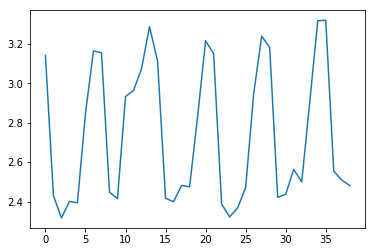

In [26]:
plt.plot(testpreds[129])

In [27]:
preddf=pd.DataFrame(testpreds,index= rrvf_data.idx_to_store(range(testpreds.shape[0]))
                    ,columns= rrvf_data.idx_to_date(range(478,478+39)))
preddf=preddf.unstack().reset_index()
preddf.columns=['date','store','transformed_visitors']
preddf['id']=preddf[['store','date']].apply(lambda u: "_".join(u.values),axis=1)
preddf['visitors']=np.expm1(preddf['transformed_visitors'])
preddf=preddf.set_index(preddf['id'])
preddf.shape

(32331, 5)

In [28]:
preddf.head()

date                 store  \
id                                                                  
air_00a91d42b08b08d9_2017-04-23  2017-04-23  air_00a91d42b08b08d9   
air_0164b9927d20bcc3_2017-04-23  2017-04-23  air_0164b9927d20bcc3   
air_0241aa3964b7f861_2017-04-23  2017-04-23  air_0241aa3964b7f861   
air_0328696196e46f18_2017-04-23  2017-04-23  air_0328696196e46f18   
air_034a3d5b40d5b1b1_2017-04-23  2017-04-23  air_034a3d5b40d5b1b1   

                                 transformed_visitors  \
id                                                      
air_00a91d42b08b08d9_2017-04-23              1.739199   
air_0164b9927d20bcc3_2017-04-23              1.293982   
air_0241aa3964b7f861_2017-04-23              2.381138   
air_0328696196e46f18_2017-04-23              2.159677   
air_034a3d5b40d5b1b1_2017-04-23              3.514781   

                                                              id   visitors  
id                                                                           
air_00a91d42b08b08d9_2017-04-23  air_00a91d42b08b08d9_2017-04-23   4.692780  
air_0164b9927d20bcc3_2017-04-23  air_0164b9927d20bcc3_2017-04-23   2.647280  
air_0241aa3964b7f861_2017-04-23  air_0241aa3964b7f861_2017-04-23   9.817209  
air_0328696196e46f18_2017-04-23  air_0328696196e46f18_2017-04-23   7.668334  
air_034a3d5b40d5b1b1_2017-04-23  air_034a3d5b40d5b1b1_2017-04-23  32.608574

In [29]:
sample=pd.read_csv("../input/sample_submission.csv")
sample.shape

(32019, 2)

In [30]:
submission=preddf[['visitors']].loc[sample['id']]
submission.shape

(32019, 1)

In [31]:
submission.to_csv("../submission/l5_3000_ridge_fold{}_{}_d{}.csv.gz".format(j, EXCLUDE_HARD, PRED_DATE)
                  ,compression='gzip')